In [1]:
using Pkg
Pkg.activate("../Project.toml")
Pkg.instantiate()

  Activating project at `~/Documents/GitHub/Drift_FeedForward`


In [2]:
#45s
#using Distributed
using Dates
using Plots
using JLD2
using LsqFit, StatsBase
using QuadGK
using Parameters
using Distributions
using SpecialFunctions
using Random
using SparseArrays
using MultivariateStats


include(joinpath(@__DIR__,"..","src","Parameter_Setting.jl"))
include(joinpath(@__DIR__,"..","src","Dynamics.jl"))
include(joinpath(@__DIR__,"..","src","reversal_learning.jl"))
include(joinpath(@__DIR__,"..","src","Babadi_Formula.jl"))
include(joinpath(@__DIR__,"..","src","Plot.jl"))

cent(X) = X .- mean(X,dims=1)
corr(X,N) = ((X' * X) / N) ./ sqrt.(diag(X'*X/N) * diag(X' * X/N)')
cov(X,N) = ((X' * X) / N)# ./ sqrt.(diag(X'*X/N) * diag(X' * X/N)')
palette_J = cgrad(:Blues,6,categorical=true)
palette_h = cgrad(:Oranges,6,categorical=true)
tmp_correlation_ϕ(y,ρ,f) = (1/2π) * quadgk(x -> (ϕ(x - Tf(f)) - f)*(ϕ(ρ*x + sqrt(1-ρ^2)*y-Tf(f))-f) * exp(-(x^2+y^2)/2), -5,5)[1]
correlation_ϕ(ρ,f) =  quadgk(y -> tmp_correlation_ϕ(y,ρ,f), -5,5)[1]/(f*(1-f))
angle_correct(θ) = θ > 0 ? θ : θ + 2π

angle_correct (generic function with 1 method)

In [3]:
p.Ns = 100
p.K = 100
p.Nc = 1000
p.P = 100
p.model = :dense_normal
ϕ(x) = x > 0 ? 1 : 0
p.f = 0.1
p.dt = 0.1
p.t_end = 3.

3.0

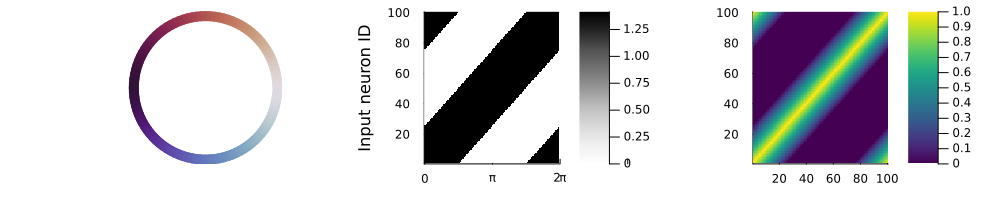

In [4]:



θ = 2π * (0:p.P-1)/p.P
center_i = Int(p.P/2)+1


x = cos.(θ)
y = sin.(θ)
colors = cgrad(:twilight, rev=true)
p0 = plot(x, y, linewidth=10, color=colors[θ ./ (2π)], aspect_ratio=:equal, legend=false,grid=false, framestyle=:none)

S = zeros(p.Ns,p.P)
for i in 1:p.Ns, n in 1:p.P
    S[i,n] = ((1≤i+n≤p.P/2) | (p.P+1≤i+n≤p.P+p.P/2)) ? sqrt(2) : 0
end
Cnz = S[:,:]
Cvec = Cnz * [cos.(θ) sin.(θ)]
Ccomp = Cvec[:,1] + Cvec[:,2]*im
Cangle = angle_correct.(angle.(Ccomp))
perm = sortperm(Cangle)
p1 = heatmap(
    θ,
    1:p.Ns, 
    Cnz[perm,:],
    colormap = :Greys,
    xticks = ([0:π:3*π;], ["0", "\\pi", "2\\pi"]),
    ylabel = "Input neuron ID"
    ) 
p2 = heatmap(cor(S),colormap = :viridis,clim=(0,1))
plot(p0, p1,p2,layout=(1,3),size=(1000,200),leftmargin=10Plots.mm,bottommargin=5Plots.mm)
#plot(p1,size=(300,240))
savefig("../figure/input_neuron_tuning.pdf")
plot!()

In [5]:
#1m10s
#similarity matrix for every σ
Random.seed!(0)
#p.f = 0.1
Nt = length(t_fixed_step(p))
N_simu = 100
σlist = [2^x for x in -1:1:1.]
C_J = zeros(p.Nc,p.P,Nt,length(σlist),N_simu)
C_h = zeros(p.Nc,p.P,Nt,length(σlist),N_simu)
h_J = zeros(p.Nc,p.P,Nt,length(σlist),N_simu)
h_h = zeros(p.Nc,p.P,Nt,length(σlist),N_simu)

for i_simu in 1:N_simu
    for i_σ in 1:length(σlist)
        p.γh = 1.; p.σh = 0.;
        p.γJ = 1.; p.σJ = σlist[i_σ];
        ϕ(x) = x > 0 ? 1 : 0
        result = simulation_sample_trajectory(p,ϕ,S,false,N_ensemble = 0);
        h_J[:,:,:,i_σ,i_simu],C_J[:,:,:,i_σ,i_simu],corr_time,active_fraction,corr_time_ensemble,active_fraction_ensemble,corr_time_theory = result

        p.γh = 1.; p.σh = σlist[i_σ];
        p.γJ = 1.; p.σJ = 0.;
        ϕ(x) = x > 0 ? 1 : 0
        result = simulation_sample_trajectory(p,ϕ,S,false,N_ensemble=0);
        h_h[:,:,:,i_σ,i_simu],C_h[:,:,:,i_σ,i_simu],corr_time,active_fraction,corr_time_ensemble,active_fraction_ensemble,corr_time_theory = result
    end
end

#jldsave("../data/hCJ_ring.jld2";h_J,C_J)
#jldsave("../data/hCh_ring.jld2";h_h,C_h)

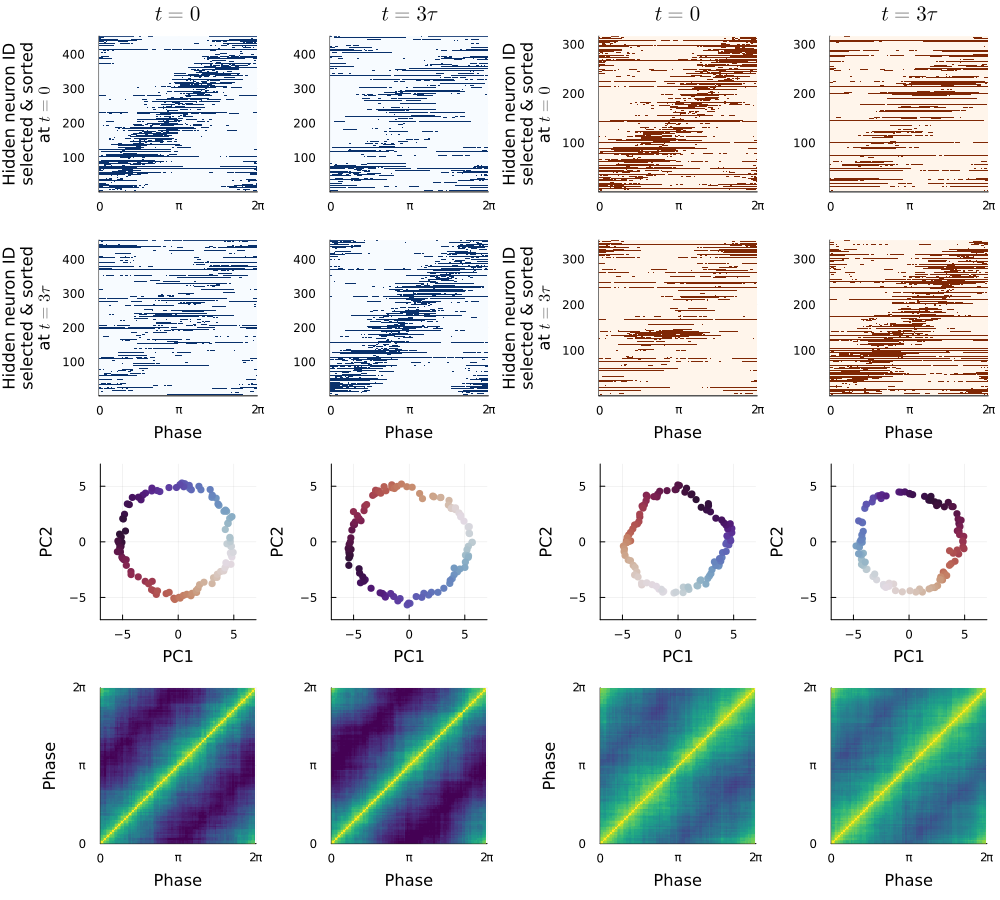

In [6]:
plot_array = Array{Any}(undef,4,4)
colorbar=false
put_ylabel = [true,false,true,false]
put_colorbar = [false,false,false,false]
title = ["\$t=0\$","\$t=3\\tau\$","\$t=0\$","\$t=3\\tau\$"]
only_responsive = false
xylim = (-7,7)
i_σ = 2; i_simu = 1

cmap = :Blues

if only_responsive
    index_responsive = sum(C_J,dims=[2,3])[:,1,1,i_σ,i_simu].>0
    C_J = C_J[index_responsive,:,:,:,:]
    h_J = h_J[index_responsive,:,:,:,:]
    println(size(C_J,1))
end
perm1 = perm_tuning_2(h_J[:,:,1,i_σ,i_simu],C_J[:,:,1,i_σ,i_simu],θ)
perm2 = perm_tuning_2(h_J[:,:,end,i_σ,i_simu],C_J[:,:,end,i_σ,i_simu],θ)
plot_array[1,:] .= plot_tuning_similarity(C_J[:,:,1,i_σ,i_simu],θ,perm1,perm2,cmap,p,colorbar,put_ylabel[1],title[1],put_colorbar[1],xylim=xylim)
plot_array[2,:] .= plot_tuning_similarity(C_J[:,:,end,i_σ,i_simu],θ,perm1,perm2,cmap,p,colorbar,put_ylabel[2],title[2],put_colorbar[2],xylim = xylim)

cmap = :Oranges
#perm1 = perm_tuning(C_h[:,:,1],θ)
#perm2 = perm_tuning(C_h[:,:,end],θ)
if only_responsive
    index_responsive = sum(C_h,dims=[2,3])[:,1,1,i_σ,i_simu].>0
    C_h = C_h[index_responsive,:,:,:,:]
    h_h = h_h[index_responsive,:,:,:,:]
    println(size(C_h,1))
end
perm1 = perm_tuning_2(h_h[:,:,1,i_σ,i_simu],C_h[:,:,1,i_σ,i_simu],θ)
perm2 = perm_tuning_2(h_h[:,:,end,i_σ,i_simu],C_h[:,:,end,i_σ,i_simu],θ)
plot_array[3,:] .= plot_tuning_similarity(C_h[:,:,1,i_σ,i_simu],θ,perm1,perm2,cmap,p,colorbar,put_ylabel[3],title[3],put_colorbar[3],xylim=xylim)
plot_array[4,:] .= plot_tuning_similarity(C_h[:,:,end,i_σ,i_simu],θ,perm1,perm2,cmap,p,colorbar,put_ylabel[4],title[4],put_colorbar[4],xylim=xylim)


plot(plot_array..., layout=(4,4),size=(1000,900))
#savefig("../figure/tuning_colorbar.pdf")
savefig("../figure/tuning_only_responsive=$(only_responsive).pdf")
plot!()

In [7]:
#8s
var_time_J = [cor(vec(cor(C_J[:,:,1,i_σ,i_simu])),vec(cor(C_J[:,:,i_time,i_σ,i_simu]))) for i_time in 1:Nt, i_simu in 1:p.P]
var_time_h = [cor(vec(cor(C_h[:,:,1,i_σ,i_simu])),vec(cor(C_h[:,:,i_time,i_σ,i_simu]))) for i_time in 1:Nt, i_simu in 1:p.P];

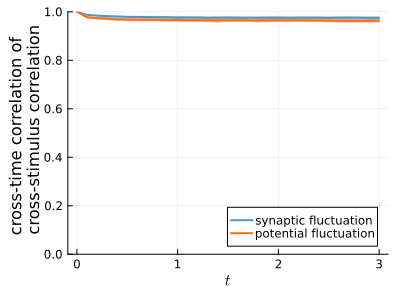

In [8]:
plot(0:p.dt:p.t_end,mean(var_time_J,dims=2)[:,1],ribbon=std(var_time_J,dims=2)[:,1],color=palette_J[4],lw=2,label="synaptic fluctuation")
plot!(0:p.dt:p.t_end,mean(var_time_h,dims=2)[:,1],ribbon=std(var_time_h,dims=2)[:,1],color=palette_h[4],lw=2,label="potential fluctuation")
plot!(ylim = (0,1),size=(400,300),xlabel="\$t\$",ylabel="cross-time correlation of \n cross-stimulus correlation")
savefig("../figure/cross-time correlation of cross-stimulus correlation.pdf")
plot!()

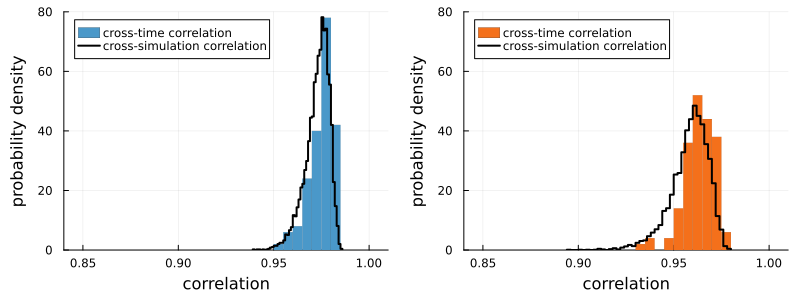

In [9]:
#10s
var_simu_J = [cor(vec(cor(C_J[:,:,end,i_σ,i_simu])),vec(cor(C_J[:,:,end,i_σ,j_simu]))) for i_simu in 1:p.P, j_simu in 1:p.P if j_simu > i_simu]
var_time_J = [cor(vec(cor(C_J[:,:,1,i_σ,i_simu])),vec(cor(C_J[:,:,end,i_σ,i_simu]))) for i_simu in 1:p.P]

var_simu_h = [cor(vec(cor(C_h[:,:,end,i_σ,i_simu])),vec(cor(C_h[:,:,end,i_σ,j_simu]))) for i_simu in 1:p.P, j_simu in 1:p.P if j_simu > i_simu]
var_time_h = [cor(vec(cor(C_h[:,:,1,i_σ,i_simu])),vec(cor(C_h[:,:,end,i_σ,i_simu]))) for i_simu in 1:p.P]

histogram(var_time_J,normalize=:pdf,label="cross-time correlation",lw=0,color=palette_J[4])
stephist!(var_simu_J,normalize=:pdf,label="cross-simulation correlation",lw=2,linecolor=:black)
p1 = plot!(size = (400,300),
    xlabel="correlation",
    ylabel="probability density",
    xlim = (0.84,1.01),
    ylim = (0,80),
    legend = :topleft)
histogram(var_time_h,normalize=:pdf,label="cross-time correlation",lw=0,color=palette_h[4])
stephist!(var_simu_h,normalize=:pdf,label="cross-simulation correlation",lw=2,linecolor=:black)
p2 = plot!(size = (400,300),
    xlabel="correlation",
    ylabel="probability density",
    xlim = (0.84,1.01),
    ylim = (0,80),
    legend = :topleft)
plot(p1,p2,layout = (1,2),size=(800,300),bottommargin=5Plots.mm,leftmargin=5Plots.mm)
savefig("../figure/cross-time correlation of similarity matrices.pdf")
plot!()

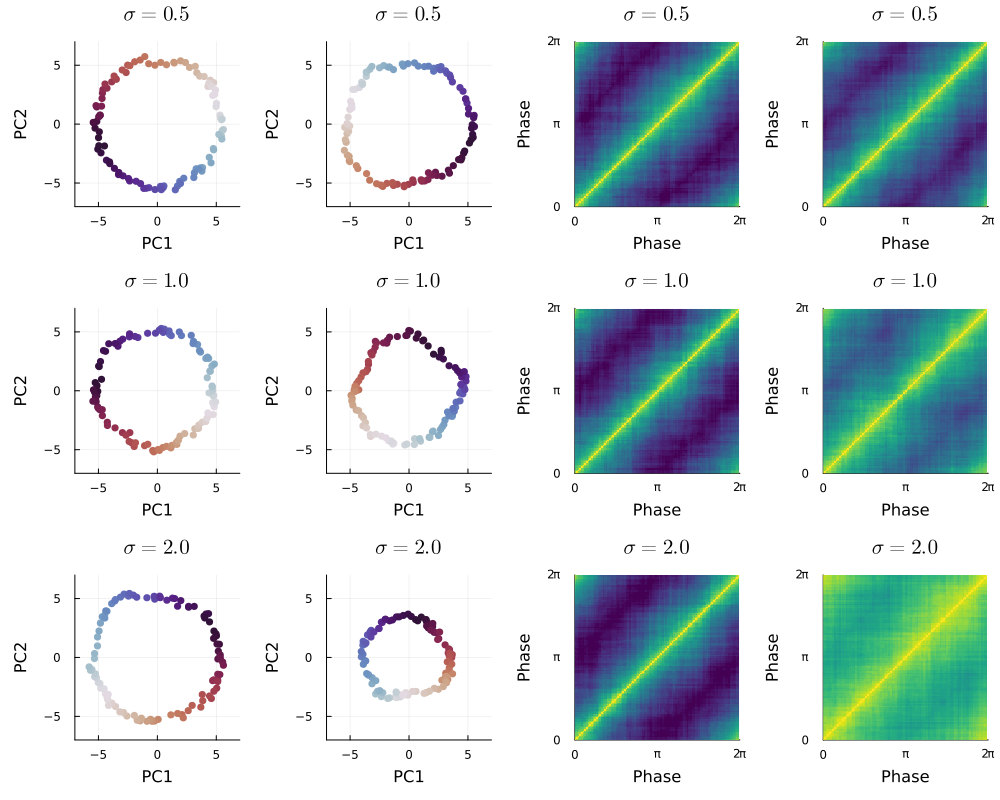

In [10]:

plot_array = Array{Any}(undef,4,length(σlist))
colorbar=false
put_ylabel = true
put_colorbar = false
title = ["\$t=0\$","\$t=3\\tau\$","\$t=0\$","\$t=3\\tau\$"]
xylim = (-7,7)
i_simu = 1
for i_σ in 1:length(σlist)
    plot_array[1,i_σ] = plot_PCA(C_J[:,:,end,i_σ,i_simu],θ,p,colorbar,put_colorbar,"\$\\sigma=$(σlist[i_σ])\$",xylim) 
    plot_array[2,i_σ] = plot_PCA(C_h[:,:,end,i_σ,i_simu],θ,p,colorbar,put_colorbar,"\$\\sigma=$(σlist[i_σ])\$",xylim)
    plot_array[3,i_σ] = plot_similarity(C_J[:,:,end,i_σ,i_simu],θ,p,colorbar,put_colorbar,put_ylabel,"\$\\sigma=$(σlist[i_σ])\$")
    plot_array[4,i_σ] = plot_similarity(C_h[:,:,end,i_σ,i_simu],θ,p,colorbar,put_colorbar,put_ylabel,"\$\\sigma=$(σlist[i_σ])\$") 
end

plot(plot_array..., layout=(length(σlist),4),size=(1000,800),leftmargin=5Plots.mm)
savefig("../figure/tuning_sigma.pdf")

for i_σ in 1:length(σlist)
    plot_array[1,i_σ] = plot_PCA(C_J[:,:,1,i_σ,i_simu],θ,p,colorbar,put_colorbar,"\$\\sigma=$(σlist[i_σ])\$",xylim) 
    plot_array[2,i_σ] = plot_PCA(C_h[:,:,1,i_σ,i_simu],θ,p,colorbar,put_colorbar,"\$\\sigma=$(σlist[i_σ])\$",xylim) 
    plot_array[3,i_σ] = plot_similarity(C_J[:,:,1,i_σ,i_simu],θ,p,colorbar,put_colorbar,put_ylabel,"\$\\sigma=$(σlist[i_σ])\$")
    plot_array[4,i_σ] = plot_similarity(C_h[:,:,1,i_σ,i_simu],θ,p,colorbar,put_colorbar,put_ylabel,"\$\\sigma=$(σlist[i_σ])\$")
end

plot(plot_array..., layout=(length(σlist),4),size=(1000,800),leftmargin=5Plots.mm)
savefig("../figure/tuning_sigma_t0.pdf")
plot!()

In [11]:
#Nc, Ns→∞ limit of similarity matrix
#=center_i = Int((length(θ)-1)/2)
points_c = [cos.(θ) sin.(θ)] .* (1 .+ 0*cos.(2θ))# + 0.01randn(length(θ),2)
points = points_c
ΣΔθ = zeros(length(θ))
for j in 1:length(θ)
    i = center_i
    ΣΔθ[j] = exp(-dot(points[i,:] - points[j,:],points[i,:] - points[j,:]))
end=#

rtol = 10^(-2.8)
tmp_correlation_ϕ_loose(y,ρ,f) = (1/2π) * quadgk(x -> (ϕ(x - Tf(f)) - f)*(ϕ(ρ*x + sqrt(1-ρ^2)*y-Tf(f))-f) * exp(-(x^2+y^2)/2), -5,5,rtol=rtol)[1]
correlation_ϕ_loose(ρ,f) =  quadgk(y -> tmp_correlation_ϕ(y,ρ,f), -5,5,rtol=rtol)[1]/(f*(1-f))
#ΣS_Δθ = (correlation_ϕ_loose.(ΣΔθ,0.5) .+ 1)/2
ΣS_Δθ = (S' * S / p.Ns)[center_i,:]
ΣS_Δθ = min.(ΣS_Δθ,1.0)
σhlist = [2^x for x in -1.:1:1]#[0.]
Σh_Δθ = zeros(length(σhlist),length(θ))
ΣC_Δθ = zeros(length(σhlist),length(θ))
Σh_Δθ_J = zeros(length(σhlist),length(θ))
ΣC_Δθ_J = zeros(length(σhlist),length(θ))
for i_σh = 1:length(σhlist)
    p.σh = σhlist[i_σh]; p.σJ = 0.
    Σh_Δθ[i_σh,:] = ((1 + p.σJ^2) * ΣS_Δθ .+ p.σh^2) / (1 + p.σJ^2 + p.σh^2)
    p.σh = 0.; p.σJ = σhlist[i_σh]
    Σh_Δθ_J[i_σh,:] = ((1 + p.σJ^2) * ΣS_Δθ .+ p.σh^2) / (1 + p.σJ^2 + p.σh^2)
    #println(maximum(Σh_Δθ[i_σh,:])," ",minimum(Σh_Δθ[i_σh,:]))
    ΣC_Δθ[i_σh,:] = correlation_ϕ_loose.(Σh_Δθ[i_σh,:],p.f)
    ΣC_Δθ_J[i_σh,:] = correlation_ϕ_loose.(Σh_Δθ_J[i_σh,:],p.f)
end

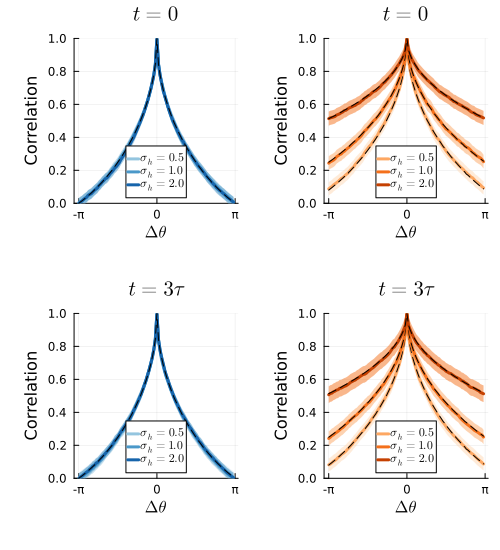

In [12]:
legend = :bottom
plot()

i_init = 1
i_end = size(C_h,3)
i_ts = [i_init,i_end]
titles = ["\$t=0\$","\$t=3\\tau\$"]

plot_array = Array{Any}(undef,length(i_ts),2)

for i_t in 1:length(i_ts)
    plot()
    i_simu = 1
    for i_σ = 1:length(σhlist)
        cor_mean = mean(stack([cor(C_J[:,:,i_ts[i_t],i_σ,i_simu])[center_i,:] for i_simu in 1:N_simu]),dims=2)
        cor_std = std(stack([cor(C_J[:,:,i_ts[i_t],i_σ,i_simu])[center_i,:] for i_simu in 1:N_simu]),dims=2)
        plot!(θ .- θ[center_i], cor_mean,ribbon = cor_std',linecolor=palette_J[i_σ+2], color=palette_J[i_σ+1],label="\$\\sigma_h=$(σhlist[i_σ])\$",linewidth=3)
        plot!(θ .- θ[center_i],ΣC_Δθ_J[i_σ,:],linecolor=:black,linestyle=:dash,label="")
    end
    plot_array[1,i_t] = plot!(ylim = (0,1),legend=legend,xticks=([-π,0,π],["-π","0","π"]),xlabel="\$\\Delta\\theta\$",ylabel = "Correlation",title=titles[i_t])
end


for i_t in 1:length(i_ts)
    plot()
    i_simu = 1
    for i_σ = 1:length(σhlist)
        cor_mean = mean(stack([cor(C_h[:,:,i_ts[i_t],i_σ,i_simu])[center_i,:] for i_simu in 1:N_simu]),dims=2)
        cor_std = std(stack([cor(C_h[:,:,i_ts[i_t],i_σ,i_simu])[center_i,:] for i_simu in 1:N_simu]),dims=2)
        plot!(θ .- θ[center_i], cor_mean,ribbon = cor_std',linecolor=palette_h[i_σ+2], color=palette_h[i_σ+1],label="\$\\sigma_h=$(σhlist[i_σ])\$",linewidth=3)
        plot!(θ .- θ[center_i],ΣC_Δθ[i_σ,:],linecolor=:black,linestyle=:dash,label="")
    end
    plot_array[2,i_t] = plot!(ylim = (0,1),legend=legend,xticks=([-π,0,π],["-π","0","π"]),xlabel="\$\\Delta\\theta\$",ylabel = "Correlation",title=titles[i_t])
end

plot(plot_array...,layout = (2,2),size=(500,550),leftmargin=5Plots.mm,bottommargin=5Plots.mm)
savefig("../figure/figure_correlation_Δθ_$(legend).pdf")
plot!()

In [13]:
#9s
i_init = 1
i_end = size(C_h,3)
i_ts = [i_init,i_end]
PCstd_J = zeros(length(σlist),N_simu,length(i_ts))
PCstd_h = zeros(length(σlist),N_simu,length(i_ts))

for i_σ = 1:length(σlist), i_simu = 1:N_simu, i_t in 1:length(i_ts)
    pca_J = fit(PCA,C_J[:,:,i_ts[i_t],i_σ,i_simu];maxoutdim=2);
    Y_J = MultivariateStats.transform(pca_J,C_J[:,:,i_ts[i_t],i_σ,i_simu])';
    pca_h = fit(PCA,C_h[:,:,i_ts[i_t],i_σ,i_simu];maxoutdim=2);
    Y_h = MultivariateStats.transform(pca_h,C_h[:,:,i_ts[i_t],i_σ,i_simu])';
    PCstd_J[i_σ,i_simu,i_t] =  std(Y_J)
    PCstd_h[i_σ,i_simu,i_t] =  std(Y_h)
end

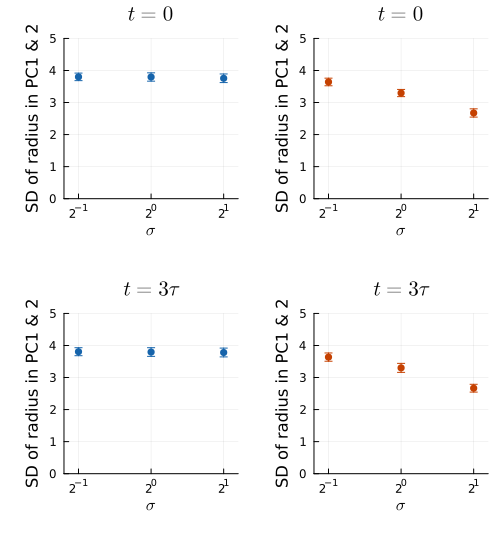

In [14]:
legend = false
color_J = cgrad(:Blues,6,categorical=true)[5]
color_h = cgrad(:Oranges,6,categorical=true)[5]

i_init = 1
i_end = size(C_h,3)
i_ts = [i_init,i_end]
titles = ["\$t=0\$","\$t=3\\tau\$"]

plot_array = Array{Any}(undef,length(i_ts),2)

for i_t in 1:length(i_ts)
    plot()
    scatter(σlist, mean(PCstd_J[:,:,i_t],dims = 2),yerror = std(PCstd_J[:,:,i_t],dims=2),markercolor=color_J,markerstrokecolor=color_J,label="Potential fluctuation (\$t=0\$)")
    plot_array[1,i_t] = plot!(xlim = (2^(-1.2),2^(1.2)),xscale = :log2, ylim = (0,5.),size = (300,300),
        xlabel = "\$\\sigma\$",
        ylabel = "SD of radius in PC1 & 2",
        title = titles[i_t],
        legend=legend)
end

for i_t in 1:length(i_ts)
    plot()
    scatter(σlist, mean(PCstd_h[:,:,i_t],dims = 2),yerror = std(PCstd_h[:,:,i_t],dims=2),markercolor=color_h,markerstrokecolor=color_h,label="Potential fluctuation (\$t=0\$)")
    plot_array[2,i_t] = plot!(xlim = (2^(-1.2),2^(1.2)),xscale = :log2, ylim = (0,5.),size = (300,300),
        xlabel = "\$\\sigma\$",
        ylabel = "SD of radius in PC1 & 2",
        title = titles[i_t],
        legend=legend)
end


plot(plot_array...,layout = (2,2),size=  (500,550),leftmargin=5Plots.mm,bottommargin=5Plots.mm)
savefig("../figure/figure_correlation_PC_std.pdf")
plot!()

In [15]:
include("../src/Plot.jl")

plot_normality_g (generic function with 1 method)

0.261600065380911240.26160006538091124


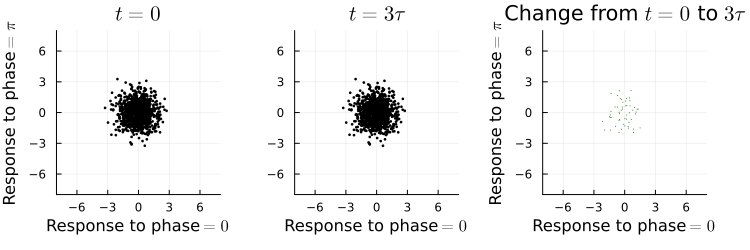

In [16]:
p.P = 2
C_0 = zeros(p.Nc,p.P,Nt)
h_0 = zeros(p.Nc,p.P,Nt)
p.γh = 1.; p.σh = 0.;
p.γJ = 1.; p.σJ = 0.;
ϕ(x) = x > 0 ? 1 : 0
result = simulation_sample_trajectory(p,ϕ,S[:,[1,center_i]],false);
h_0[:,:,:],C_0[:,:,:],corr_time,active_fraction,corr_time_ensemble,active_fraction_ensemble,corr_time_theory = result
h_A = h_0[:,1,:,1]
h_B = h_0[:,2,:,1]
p0 = plot_selectivity_space(h_A,h_B)
plot(p0,layout=(1,1),size=(750,250),bottommargin=5Plots.mm,leftmargin=3Plots.mm)
savefig("../figure/selectivity_space_0.pdf")
plot!()

-1.8789512087402627-1.6667278795926084
-0.34879198040923376-2.0658517254833404


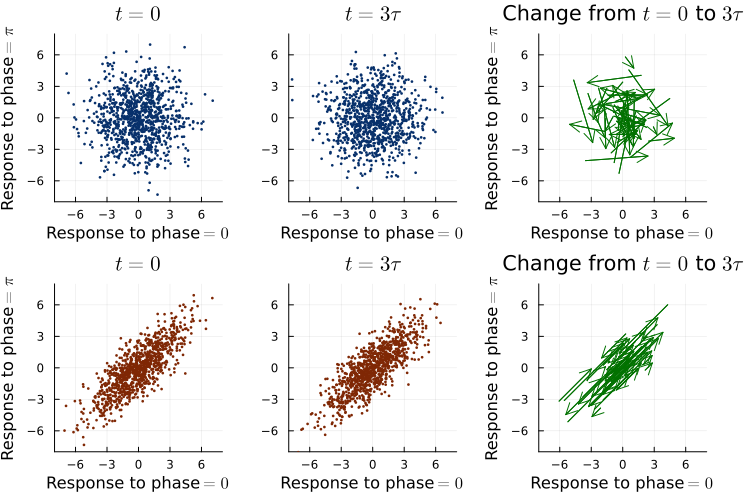

In [17]:

Random.seed!(0)
i_σ = 3; i_simu = 1;
h_A = h_J[:,1,:,i_σ,i_simu]
h_B = h_J[:,center_i+1,:,i_σ,i_simu]
p1 = plot_selectivity_space(h_A,h_B,color=palette_J[6])
h_A = h_h[:,1,:,i_σ,i_simu]
h_B = h_h[:,center_i+1,:,i_σ,i_simu]
p2 = plot_selectivity_space(h_A,h_B,color=palette_h[6])
plot(p1,p2,layout=(2,1),size=(750,500))
savefig("../figure/selectivity_space.pdf")
plot!()

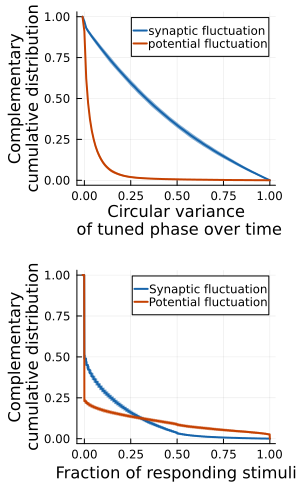

In [25]:
#15s
#Fig. S4 is output as "tuning_property_summary_across_t.pdf"
plot()
i_σ = 3
xs = -0.01:0.001:1.
ecdf_h = zeros(N_simu,length(xs),2)
ecdf_J = zeros(N_simu,length(xs),2)
for i_simu in 1:N_simu
    stim_sparse_h = mean(C_h[:,:,1,3,i_simu].>0,dims=2)[:,1]
    #stim_sparse_h = stim_sparse_h[stim_sparse_h .> 0]
    stim_sparse_J = mean(C_J[:,:,1,3,i_simu].>0,dims=2)[:,1]
    #stim_sparse_J = stim_sparse_J[stim_sparse_J .> 0]
    ecdf_h[i_simu,:,1] = ecdf(stim_sparse_h).(xs)
    ecdf_J[i_simu,:,1] = ecdf(stim_sparse_J).(xs)
    stim_sparse_h = mean(C_h[:,:,end,3,i_simu].>0,dims=2)[:,1]
    #stim_sparse_h = stim_sparse_h[stim_sparse_h .> 0]
    stim_sparse_J = mean(C_J[:,:,end,3,i_simu].>0,dims=2)[:,1]
    #stim_sparse_J = stim_sparse_J[stim_sparse_J .> 0]
    ecdf_h[i_simu,:,2] = ecdf(stim_sparse_h).(xs)
    ecdf_J[i_simu,:,2] = ecdf(stim_sparse_J).(xs)
end

plot(xs,1 .- mean(ecdf_J[:,:,1],dims=1)',ribbon = std(ecdf_J[:,:,1],dims=1)',color=palette_J[5],linewidth=2,label="Synaptic fluctuation")
plot!(xs,1 .- mean(ecdf_h[:,:,1],dims=1)',ribbon = std(ecdf_h[:,:,1],dims=1)',color = palette_h[5],linewidth=2,label="Potential fluctuation")
p0t = plot!(xlabel="Fraction of responding stimuli",ylabel="Complementary\ncumulative distribution",title= "\$t=0\$")

plot(xs,1 .- mean(ecdf_J[:,:,end],dims=1)',ribbon = std(ecdf_J[:,:,end],dims=1)',color=palette_J[5],linewidth=2,label="Synaptic fluctuation")
plot!(xs,1 .- mean(ecdf_h[:,:,end],dims=1)',ribbon = std(ecdf_h[:,:,end],dims=1)',color = palette_h[5],linewidth=2,label="Potential fluctuation")
p1t = plot!(xlabel="Fraction of responding stimuli",ylabel="Complementary\ncumulative distribution",title = "\$t=3\\tau\$")
plot(p0t,p1t,layout=(1,2),size = (600,250),leftmargin=5Plots.mm,bottommargin=5Plots.mm)
savefig("../figure/tuning_property_summary_across_t.pdf")
plot!()


function rotational_variance_over_time(C)
    time_having_tuning = [mean(C,dims=1)[1,i_time] ∉ [0,1] for i_time in 1:size(C,2)] 
    Δuθ = C[:,time_having_tuning]' * [cos.(θ) sin.(θ)]
    Δuθ = Δuθ[(sum(Δuθ.^2,dims=2).>eps())[:,1],:]
    Δuθ = Δuθ ./ sqrt.(sum(Δuθ.^2,dims=2))
    θvar = 1 - sum(mean(Δuθ,dims=1).^2)
end

θvar_h = zeros(p.Nc,N_simu)
θvar_J = zeros(p.Nc,N_simu)
for i_cell in 1:p.Nc, i_simu in 1:N_simu
    θvar_h[i_cell,i_simu] = rotational_variance_over_time(C_h[i_cell,:,:,i_σ,i_simu])
    θvar_J[i_cell,i_simu] = rotational_variance_over_time(C_J[i_cell,:,:,i_σ,i_simu])
end

θs = -0.01:0.01:1
θvars = stack([(ecdf(θvar_J[.!isnan.(θvar_J[:,i_simu]),i_simu]).(θs)) for i_simu in 1:N_simu])
plot(θs, 1 .- mean(θvars,dims=2),ribbon=std(θvars,dims=2),color=palette_J[5],label="synaptic fluctuation",linewidth=2)
θvars = stack([(ecdf(θvar_h[.!isnan.(θvar_h[:,i_simu]),i_simu]).(θs)) for i_simu in 1:N_simu])
plot!(θs, 1 .- mean(θvars,dims=2),ribbon=std(θvars,dims=2),color=palette_h[5],label="potential fluctuation",linewidth=2)
p2 = plot!(xlabel = "Circular variance\n of tuned phase over time", ylabel = "Complementary\ncumulative distribution")
p1 = deepcopy(p1t)
plot(p1)
p1 = plot!(xlabel="Fraction of responding stimuli",ylabel="Complementary\ncumulative distribution",title = "")
plot(p2,p1,layout=(2,1),size = (300,500),leftmargin=2Plots.mm,rightmargin=4Plots.mm)
savefig("../figure/tuning_property_summary.pdf")
plot!()